<a href="https://colab.research.google.com/github/EcatFryyy/Diffuser-test-1/blob/main/09_diffusers_api.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stable diffusion with Diffusers

This is a notebook that demonstrates how to use the [Diffusers package](https://huggingface.co/docs/diffusers/index) from Huggingface to run stable diffusion. [Huggingface](https://huggingface.co) is a community-driven  platform that provides a comprehensive suite of open-source libraries and tools for machine learning. Think of it as a kind of "github for machine learning". The diffusers package provides a simple API and a number of pretrained models that allow to easily run and experiment with diffusion models. 

**NOTE** this notebook should work on other platform, but it has been only tested on Mac (M1). 



In [ ]:
!pip install diffusers
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Running stable diffusion
To run stable diffusion you will need to distinguish wether you are running this on a Mac M1/M2 or on Linux/Windows with a Nvidia GPU. 
On a M1/M2 Mac, diffusion will need a "warmup" phase to work properly (see [this link](https://huggingface.co/docs/diffusers/optimization/mps))

In [ ]:
import platform
if platform.processor() == 'arm':
    print("Detected Mac M1/M2")
    device = 'mps'
else:
    print("Possibliy detected GPU")
    device = 'cuda'

Possibliy detected GPU


Now this will load the pretrained model and download it the first time the cell is run (which might take a while).

In [ ]:
from diffusers import StableDiffusionPipeline
generator = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")
generator = generator.to(device)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
/usr/local/lib/python3.9/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [ ]:
if device=='mps':
    # Recommended if your computer has < 64 GB of RAM
    generator.enable_attention_slicing()

prompt = "A cubist painting of the Star Treck character Spock, high quality, trending on artstation"

if device=='mps':
    # First-time "warmup" pass for M1/M2 macs
    _ = generator(prompt, num_inference_steps=1)


Generate the image (note increasing `num_inference_steps` will improve quality but be slower)

In [ ]:

image = generator(prompt, num_inference_steps=20).images[0]

  0%|          | 0/20 [00:00<?, ?it/s]

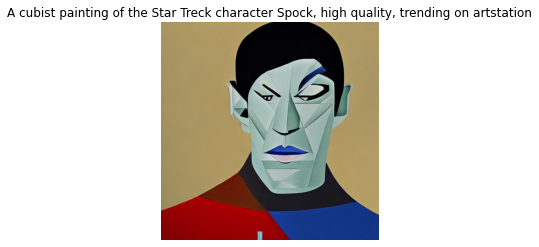

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.imshow(np.array(image))
plt.title(prompt)
plt.axis('off')
plt.show()

## Conditioning stable diffusion with ControlNet

[ControlNet](https://stablediffusionweb.com/ControlNet) is a very recent and quite amazing advancement in image generation using stable diffusion. It allows conditioning the stable diffusion generation pipeline on an image input (similarly to pix2pix).


In [ ]:
!pip install accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.8/212.8 KB 5.3 MB/s eta 0:00:00


In [ ]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
import torch

controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)

Let's use skimage to create edges

uint8 255


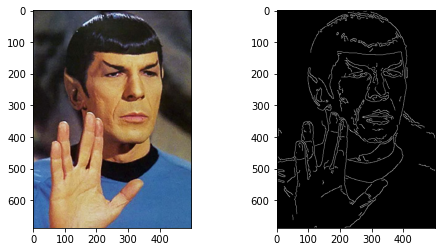

In [ ]:
import numpy as np
from skimage import io, feature
import matplotlib.pyplot as plt
import PIL.Image as Image
import cv2

def apply_canny_skimage(img, sigma=1.5):
    import cv2
    from skimage import feature
    invert = False
    grayimg = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edges = (feature.canny(grayimg, sigma=sigma)*255).astype(np.uint8)
    if invert:
        edges = cv2.bitwise_not(edges)
    print(edges.dtype, np.max(edges))
    return cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)

img = io.imread("spock.jpg")
edges =  apply_canny_skimage(img)

# ControlNet expects a PIL Image as input
edges_image = Image.fromarray(edges)

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(edges)
plt.show()

Setup the ControlNet model. Somehow converting to device takes ages on Mac. Here we use the canny-to-image model, there are others available: 
[https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion/controlnet](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion/controlnet)

In [ ]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
import torch
import PIL.Image as Image

controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-canny", 
    torch_dtype=torch.float16)
    
generator = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
    controlnet=controlnet, 
    safety_checker=None)
print("converting to device")
generator = generator.to(device)


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


converting to device


In [ ]:
prompt = "A sculpture made of clay on a white background"

if device=='mps':
    generator.enable_attention_slicing()
    _ = generator(prompt, image=edges_image, num_inference_steps=1)
else:
    # this command loads the individual model components on GPU on-demand.
    generator.enable_model_cpu_offload()



  0%|          | 0/30 [00:00<?, ?it/s]

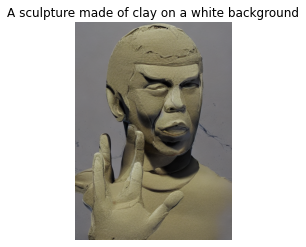

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

image = generator(
    prompt,
    image=edges_image,
    num_inference_steps=30,
).images[0]

plt.imshow(np.array(image))
plt.title(prompt)
plt.axis('off')
plt.show()